In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import urllib
import sys
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D     
import collections
from itertools import combinations

from pymodulon.core import IcaData
from os.path import abspath, join
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm
from pymodulon.plotting import *
from pymodulon.io import load_json_model
from pymodulon.io import *
from pymodulon.compare import *
from matplotlib_venn import venn3, venn3_circles
from graphviz import Digraph

import upsetplot
from upsetplot import plot
from upsetplot import from_contents
from upsetplot import UpSet

In [2]:
import matplotlib
import matplotlib.font_manager
# plt.style.use('figures')
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
ica_data = load_json_model('../json/core.json')

# Figure 1

## Tree

See R notebook section "tree visualization"

## Sensitivity Analysis

In [4]:
pangenome = pd.read_csv('../pangenome/pangenome_matrix.csv',index_col=0)

In [5]:
df = pd.read_csv('../pangenome/metadata.csv',dtype=str)
tree_genome = list(df['Genome ID'])
tree_genome = list([str(g) for g in tree_genome])
selected_pangenome = pangenome[pangenome.columns[pangenome.columns.isin(tree_genome)]]

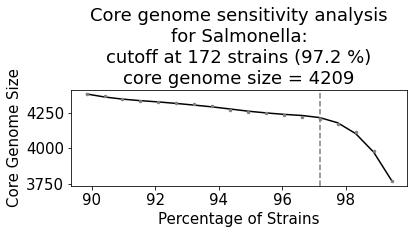

In [6]:
from scipy.signal import savgol_filter
from collections import OrderedDict
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, ax = plt.subplots(1,1, figsize = (6,3.5))
i = 0

cutoffs = {}
  
cdhit_in_genomes = selected_pangenome

no_genomes_range = [i for i in range(int(90*cdhit_in_genomes.shape[1]/100), cdhit_in_genomes.shape[1])]
cutoff2core = {100*i/cdhit_in_genomes.shape[1]:sum(cdhit_in_genomes.sum(axis = 1) >= i) for i in no_genomes_range}
cutoff2core = OrderedDict(sorted(cutoff2core.items(), key = lambda a:a[0]))

Xrange, Ydata = np.array(list(cutoff2core.keys())), np.array(list(cutoff2core.values()))
Ypred = savgol_filter(Ydata , 9, 3)
ax.plot(Xrange, Ypred, '-', color = 'k')
ax.plot(Xrange, Ydata, '.', color = 'grey', markersize = 5)
ax.set_xlabel('Percentage of Strains')
ax.set_ylabel('Core Genome Size')

cutoff = list(cutoff2core.keys())[sum(abs(np.diff(np.array(list(cutoff2core.values())))) < 0.01*min(cutoff2core.values()))]
ax.axvline(cutoff, linestyle = 'dashed', color = 'grey')
no_strains = int(cutoff*cdhit_in_genomes.shape[1]/100)
text = 'Core genome sensitivity analysis\nfor %s:\ncutoff at %s strains (%s %%)\ncore genome size = %s'%('Salmonella', no_strains, str(round(cutoff,1)), str(cutoff2core[cutoff]))
ax.set_title(text)

    
plt.tight_layout()
plt.savefig('../Figures/F1b.pdf',transparent=True)

In [7]:
tree_table = pd.DataFrame(np.zeros([115,1]),index = ica_data.imodulon_table.index, columns=['Size'])

In [8]:
for imod in ica_data.imodulon_table.index:
    size = ica_data.view_imodulon(imod).shape[0]
    tree_table.loc[imod] = size

## Stats plot

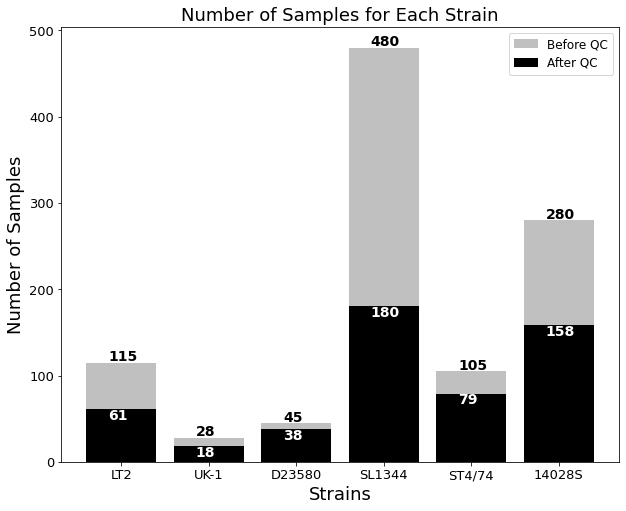

In [9]:
strains = ['LT2','UK-1','D23580','SL1344','ST4/74','14028S']
before_qc = [115,28,45,480,105,280]
after_qc = [61,18,38,180,79,158]
plt.figure(figsize=[10,8])
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.xlabel('Strains',fontsize=18)
plt.ylabel('Number of Samples',fontsize=18)
plt.bar(strains,before_qc,label='Before QC',color='silver')
for index, value in enumerate(before_qc):
    plt.text(index-0.15, value+2,str(value),fontsize=14,weight='semibold')
plt.bar(strains,after_qc,label='After QC',color='black')
for index, value in enumerate(after_qc):
    plt.text(index-0.15, value-12,str(value),fontsize=14,weight='semibold',color='white')
plt.legend(loc='best',fontsize=12)
plt.title('Number of Samples for Each Strain',fontsize=18)
plt.savefig('../Figures/F1c.pdf',transparent=True)

# Figure 2

## PR

In [10]:
regulatory = pd.read_csv('../data/Core/processed_data/regulatory_imod_categories.csv')

In [11]:
reg = regulatory[['imodulon_size','precision','recall','category']]

In [12]:
colors = {'Energy Production':'#1F78B4', 'Metabolism':'#B2DF8A', 'Metal Homeostasis':'#33A02C', 
          'Motility':'#FB9A99','Resistance':'#E31A1C','Stress Response':'#FDBF6F', 'Structure':'#FF7F00', 
          'Transcription':'#CAB2D6','Translation':'#6A3D9A','Virulence':'#A6CEE3'}

In [13]:
s = reg.imodulon_size
s = [x**1.6 for x in s]
c = list(reg['category'].map(colors))

In [14]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=s,c=c,edgecolor='grey',linewidth=1.2,alpha=1)
#     legend = ax.legend(['Energy Production','Metabolism', 'Metal Homeostasis', 'Motility',
#                         'Stress Response', 'Structure','Transcription','Translation','Virulence'],
#                        bbox_to_anchor=(1.35, 1), loc='upper left')
    ax.set_xlabel('Regulon Recall',fontsize=18)
    ax.set_ylabel('iModulon Recall',fontsize=18)
    ax.tick_params(axis='x', labelsize= 10) 
    ax.tick_params(axis='y', labelsize= 10) 

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = 20
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    ax_histx.tick_params(axis='x', labelsize= 10) 
    ax_histy.tick_params(axis='y', labelsize= 10) 

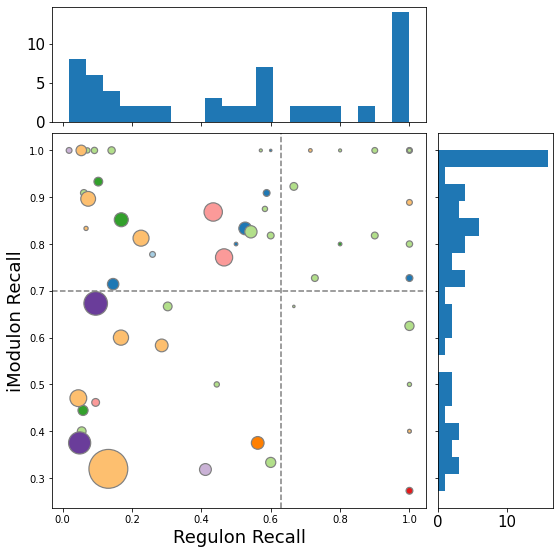

<Figure size 432x288 with 0 Axes>

In [15]:
left, width = 1, 0.65
bottom, height = 1, 0.65
spacing = 0.02


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(reg['precision'],reg['recall'],ax,ax_histx, ax_histy)
ax.axvline(0.63, linestyle = 'dashed', color = 'grey')
ax.axhline(0.7, linestyle = 'dashed', color = 'grey')


plt.show()
plt.savefig('../Figures/F2a.pdf',transparent=True)

## Treemap

See R notebook section "treemap"

## Category pie chart

In [16]:
category = pd.read_csv('../data/Core/processed_data/core_treemap.csv')

In [17]:
names = list(Counter(category.imod_type).keys())
group_size = list(Counter(category.imod_type).values())

In [18]:
group_names=[]
for i in range(len(names)):
    pct = round(100*group_size[i]/sum(group_size),2)
    group_names.append(names[i] + '(' + str(group_size[i]) + ')')

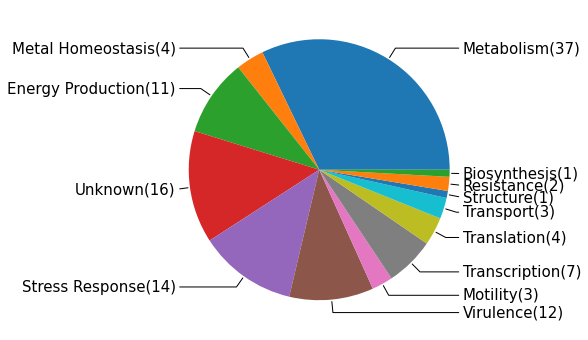

In [19]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(group_size)


# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, 
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(group_names[i], xy=(x, y), xytext=(1.1*np.sign(x),1.1*y),
                horizontalalignment=horizontalalignment, **kw)
None
plt.savefig('../Figures/F2c.pdf',transparent=True)

## Explained variance

In [20]:
variance = []
for i in ica_data.imodulon_table.index:
    exp_var = explained_variance(ica_data,imodulons=i)
    variance.append(exp_var)

In [21]:
variance = pd.DataFrame(variance, index = ica_data.imodulon_table.index, columns = ['Explained Variance'])
variance = variance.sort_values(by='Explained Variance', ascending = False)

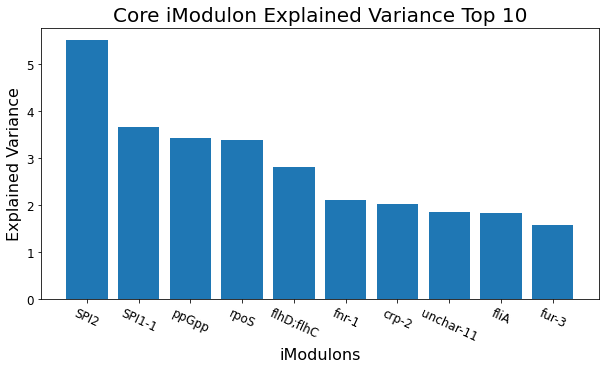

In [22]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=-25,fontsize=12)  #rotation=-90
plt.yticks(fontsize=12)
plt.bar(variance[0:10].index,variance['Explained Variance'][0:10],label='Explained Variance')
plt.xlabel('iModulons',fontsize=16)
plt.ylabel('Explained Variance',fontsize=16)
plt.title('Core iModulon Explained Variance Top 10',fontsize=20)
plt.savefig('../Figures/F2d.pdf',transparent=True)

# Figure 3

## crp category breakdown

In [23]:
cat = dict(collections. Counter(ica_data.view_imodulon('crp-2')['COG']))

In [24]:
l = ica_data.view_imodulon('crp-2').shape[0]
key = []
val = []
for k in cat:
    pct = round(100*cat[k]/l, 2)
    key.append(str(k)+ '(' + str(cat[k]) + ')')
    val.append(cat[k])

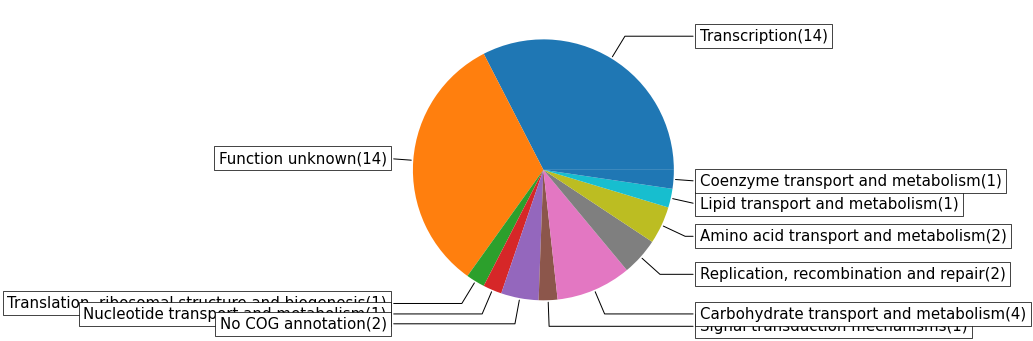

In [25]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(val)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(key[i], xy=(x, y), xytext=(1.2*np.sign(x),1.2*y),
                horizontalalignment=horizontalalignment, **kw)
None
plt.savefig('../Figures/F3a.pdf',transparent=True)

## crp metadata boxplot

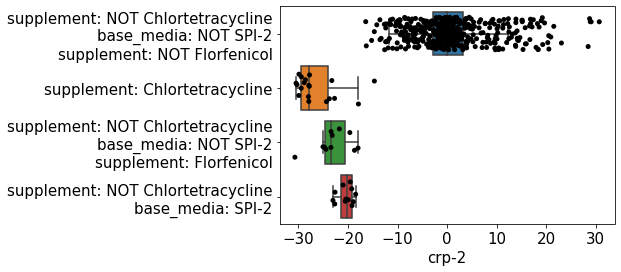

In [26]:
metadata_boxplot(ica_data,'crp-2',use_cols=['supplement','base_media'],n_boxes=4)
figure = plt.gcf()
figure.savefig('../Figures/F3b.pdf',transparent=True)

## SPI-1/SPI-4 venn diagram

In [27]:
SPI4 = set(['STM4257', 'STM4258', 'STM4259', 'STM4260', 'STM4261' ,'STM4262'])
SPI1 = set(['STM2861','STM2862', 'STM2863','STM2864','STM2865','STM2866','STM2867','STM2868','STM2869','STM2870',
            'STM2871','STM2872','STM2873','STM2874','STM2875','STM2876','STM2877','STM2878','STM2879','STM2881',
            'STM2882','STM2883','STM2884','STM2885','STM2886','STM2887','STM2888','STM2889','STM2890','STM2891',
            'STM2892','STM2893','STM2894','STM2895','STM2896','STM2897','STM2898','STM2899','STM2900','invR','STM2901',
            'STM2902','STM2903','STM2904','STM2905','STM2906'])

In [28]:
spi1_imod = set(ica_data.view_imodulon('SPI1-1').index)

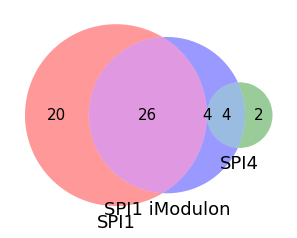

In [29]:
venn3([SPI1,SPI4,spi1_imod],('SPI1','SPI4','SPI1 iModulon'))
figure = plt.gcf()
figure.savefig('../Figures/F3c.pdf',transparent=True)

## hilD DIMA plot

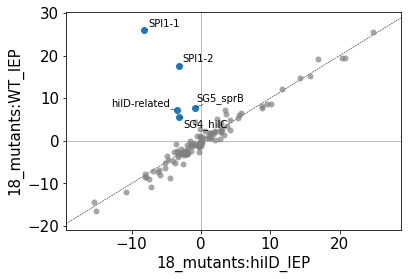

In [30]:
plot_dima(ica_data,'18_mutants:hilD_IEP','18_mutants:WT_IEP')
figure = plt.gcf()
figure.savefig('../Figures/F3d.pdf',transparent=True)

# Figure 4

## Bar plot

In [31]:
strains = ['SL1344','ST4/74','14028S','LT2','D23580','UK-1']
reg = [35,20,27,14,13,4]
genomic = [2,4,0,1,0,3]
functional = [18,11,17,15,7,2]
unknown = [12,28,8,14,13,5]
SG = [0,2,4,3,2,1]

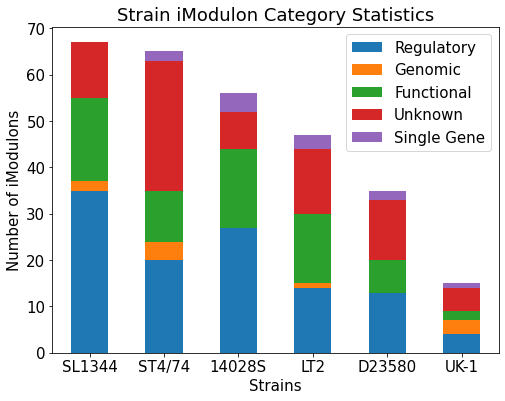

In [32]:
df=pd.DataFrame({'Regulatory':reg, 'Genomic':genomic, 'Functional':functional,'Unknown':unknown,
                 'Single Gene':SG},index=strains)
df.plot(kind='bar', stacked=True,figsize=(8,6),title='Strain iModulon Category Statistics',xlabel='Strains',
       ylabel='Number of iModulons',rot=0)
figure = plt.gcf()
figure.savefig('../Figures/F4a.pdf',transparent=True)

## RBH graph

In [33]:
# Set data directory
data_dir = os.path.join('../data')

# Get list of strains
strains = os.listdir(data_dir)
strains.remove('Core')
print(strains)

['ST4_74', 'UK_1', 'SL1344', '14028S', 'LT2', 'D23580']


In [34]:
# Load objects

objects = {}

for strain in strains:
    if strain != 'Core':
        objects[strain] = load_json_model(os.path.join('../json',strain+'.json'))
objects

{'ST4_74': <pymodulon.core.IcaData at 0x7fa4b0dca7f0>,
 'UK_1': <pymodulon.core.IcaData at 0x7fa4b193ff10>,
 'SL1344': <pymodulon.core.IcaData at 0x7fa4af402100>,
 '14028S': <pymodulon.core.IcaData at 0x7fa4b16f1220>,
 'LT2': <pymodulon.core.IcaData at 0x7fa4af7e2790>,
 'D23580': <pymodulon.core.IcaData at 0x7fa4b0dc5970>}

In [35]:
all_links = []

cutoff = 0.3

for strain1,strain2 in combinations(strains,2):
    
    # Get ortho file (sometimes need to switch order)
    try:
        links,dot = compare_ica(objects[strain1].M,
                        objects[strain2].M,
                        ortho_file = os.path.join('../pangenome/bbh_results',strain1+'_vs_'+strain2+'_parsed.csv'),
                        cutoff=cutoff)
    except:
        # Switch order if necessary
        tmp = strain1
        strain1 = strain2
        strain2 = tmp
        links,dot = compare_ica(objects[strain1].M,
                        objects[strain2].M,
                        ortho_file = os.path.join('../pangenome/bbh_results',strain1+'_vs_'+strain2+'_parsed.csv'),
                        cutoff=cutoff)
        
    # Remove single-gene iModulons
    sg_mods1 = objects[strain1].find_single_gene_imodulons()
    sg_mods2 = objects[strain2].find_single_gene_imodulons()

    links = [(k1,k2,dist) for (k1,k2,dist) in links if k1 not in sg_mods1 and k2 not in sg_mods2]

    # Make a pandas dataframe for the links
    DF_links_tmp = pd.DataFrame(links,columns=['imod1','imod2','distance'])
    DF_links_tmp['strain1'] = strain1
    DF_links_tmp['strain2'] = strain2
    
    # Add to list of all links
    all_links.append(DF_links_tmp)

# Create final dataframe of all links
DF_links = pd.concat(all_links).reset_index(drop=True)

In [36]:
DF_links

,imod1,imod2,distance,strain1,strain2
0,SPI1,SPI1,0.586847,ST4_74,UK_1
1,SPI1,SPI1,0.788554,ST4_74,SL1344
2,12,plasmid-associated-2,0.446970,ST4_74,SL1344
3,fliA,fliA,0.487806,ST4_74,SL1344
4,fliA,flhD;flhC,0.352044,ST4_74,SL1344
...,...,...,...,...,...
153,arcA-2,fnr-1,0.381358,D23580,LT2
154,fur,fur,0.516200,D23580,LT2
155,uncharacterized-6,O-antigen,0.457201,D23580,LT2
156,SPI1,SPI1,0.734432,D23580,LT2


In [37]:
def get_edge_color(dist):
    hex_code = '{:2x}'.format(int((1-dist)*255)).replace(' ','0')
    return '#'+hex_code*3

In [38]:
strain_color = dict(zip(strains,['blue','red','green','yellow','cyan','orange']))
strain_color

{'ST4_74': 'blue',
 'UK_1': 'red',
 'SL1344': 'green',
 '14028S': 'yellow',
 'LT2': 'cyan',
 'D23580': 'orange'}

In [39]:
dot = Digraph(engine='circo',graph_attr={'splines':'false','bgcolor':'transparent'})
nodes = []
for i,row in DF_links.iterrows():
    node1 = row.strain1+'_'+str(row.imod1)
    node2 = row.strain2+'_'+str(row.imod2)
    
    if node1 not in nodes:
        dot.node(node1,shape='circle',label='',width='.2',tooltip=node1,
                 height='.2',fillcolor=strain_color[row.strain1],
                 style='filled',color='black',penwidth='1')
        
    if node2 not in nodes:
        dot.node(node2,shape='circle',label='',width='.2',tooltip=node2,
                 height='.2',fillcolor=strain_color[row.strain2],
                 style='filled',color='black',penwidth='1')   
        
    dot.edge(node1,node2,_attributes={'arrowhead':'none','color':get_edge_color(row.distance),
                                      'penwidth':'{:.2f}'.format(8*(row.distance))})

In [40]:
dot
dot.render('../Figures/F4b')

'../Figures/F4b.pdf'

## Six strain tree

See R notebook section

## SPI-1 iModulons clustermap

In [41]:
imods = ['SPI1','SPI1-1','SPI1-2']
ls = []
for i in DF_links.index:
    if str(DF_links.loc[i].imod1) in imods and str(DF_links.loc[i].imod2) in imods:
        ls.append(i)
SPI1s = DF_links.loc[ls]

In [42]:
columns = [SPI1s.loc[i].strain1 + '-' + SPI1s.loc[i].imod1 for i in SPI1s.index]+ [SPI1s.loc[i].strain2 + '-' + SPI1s.loc[i].imod2 for i in SPI1s.index]
l = len(np.unique(columns))
SPI1_DF = pd.DataFrame(np.zeros((l,l)),columns = np.unique(columns),index=np.unique(columns))

In [43]:
for i in SPI1s.index:
    row = SPI1s.loc[i].strain1 + '-' + SPI1s.loc[i].imod1
    column = SPI1s.loc[i].strain2 + '-' + SPI1s.loc[i].imod2
    val = SPI1s.loc[i].distance
    SPI1_DF.loc[row][column] = val
    SPI1_DF.loc[column][row] = val
    SPI1_DF.loc[row][row] = 1
    SPI1_DF.loc[column][column] = 1

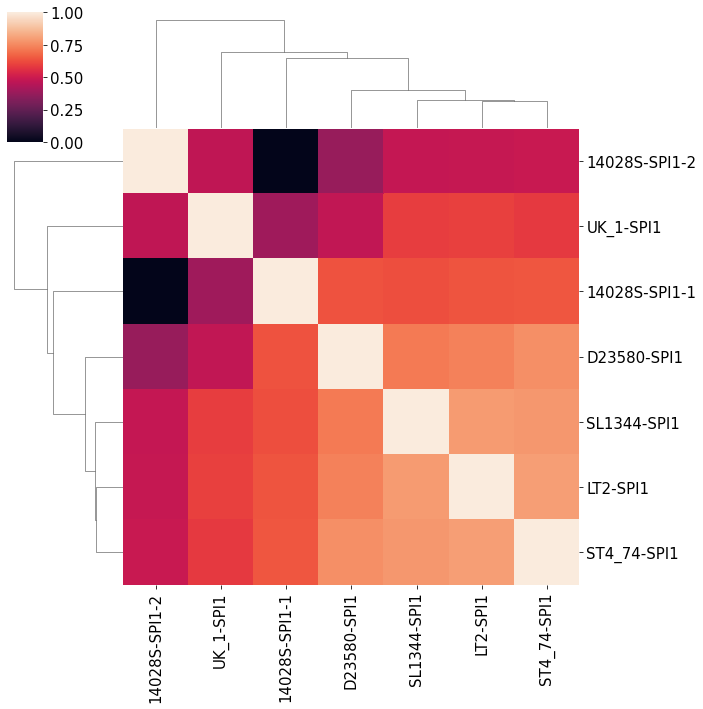

In [44]:
g = sns.clustermap(SPI1_DF)
figure = plt.gcf()
figure.savefig('../Figures/F4d.pdf',transparent=True)

## SPI-1 UpSet plot

In [45]:
strains = ['LT2','14028S','SL1344','ST4_74','D23580','UK_1']
my_dict = {}
for strain in strains:
    strain_json = load_json_model('../json/'+ strain + '.json')
    bbh = pd.read_csv(path.join('../pangenome/bbh_results/' + strain + '_vs_LT2_parsed.csv'),index_col=0)
    bbh = bbh[['gene','subject']]
    if 'SPI1-1' not in strain_json.imodulon_table.index:
        strain_spi1 = strain_json.view_imodulon('SPI1')
    else: 
        strain_spi1 = pd.concat([strain_json.view_imodulon('SPI1-1'),strain_json.view_imodulon('SPI1-2')])
    for name in strain_spi1.index:
        if name in list(bbh.gene):
            idx = list(bbh.gene).index(name)
            tag = list(bbh.subject)[idx]
            strain_spi1.at[name,'gene_name'] = tag
        else: strain_spi1.at[name,'gene_name'] = name
    my_dict[strain] = set(strain_spi1.gene_name)

In [46]:
LT2_spi1 = set(my_dict['LT2'])
SL1344_spi1 = set(my_dict['SL1344'])
_14028S_spi1 = set(my_dict['14028S'])
ST4_74_spi1 = set(my_dict['ST4_74'])
D23580_spi1 = set(my_dict['D23580'])
UK_1_spi1 = set(my_dict['UK_1'])

In [47]:
SL1344_spi1.add('STM474_2826')
SL1344_spi1.remove('SL1344_2674')

In [48]:
core_spi1 = set(pd.concat([ica_data.view_imodulon('SPI1-1'),ica_data.view_imodulon('SPI1-2')]).index)

In [49]:
mydict = {'Core':core_spi1,'LT2':LT2_spi1,'SL1344':SL1344_spi1,
     'D23580':D23580_spi1,'ST474': ST4_74_spi1,'14028S':_14028S_spi1, 'UK_1':UK_1_spi1}

In [50]:
SPI1 = from_contents(mydict)
SPI1

id
Core  LT2   SL1344 D23580 ST474 14028S UK_1            
True  True  True   True   True  True   True     STM2900
                                       True     STM1855
                                       True     STM2881
                                       True     STM2872
                                       True     STM4313
...                                                 ...
False False False  False  False False  True     STM1154
                                       True  STMUK_3610
                                       True  STMUK_2280
                                       True     STM3821
                                       True     STM3822

[161 rows x 1 columns]

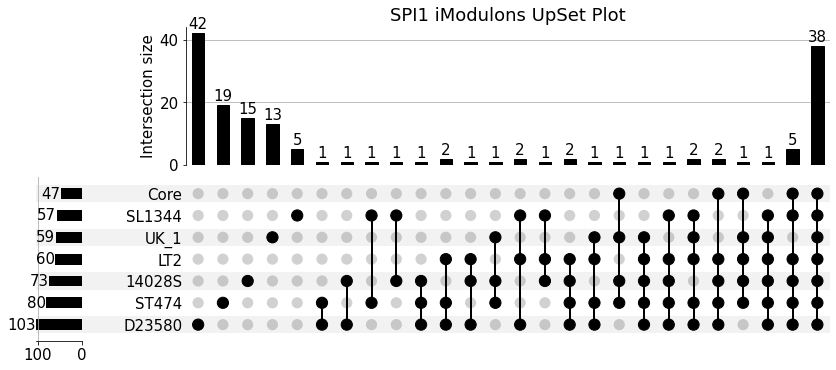

In [51]:
UpSet(SPI1,show_counts=True).plot()
plt.title('SPI1 iModulons UpSet Plot')
plt.savefig('../Figures/F4e.pdf',transparent=True)

## SPI-2 iModulons clustermap

In [52]:
ls = []
for i in DF_links.index:
    if 'SPI2' in str(DF_links.loc[i].imod1):
        ls.append(i)
SPI2s = DF_links.loc[ls]

In [53]:
columns = [SPI2s.loc[i].strain1 + '-' + SPI2s.loc[i].imod1 for i in SPI2s.index]+ [SPI2s.loc[i].strain2 + '-' + SPI2s.loc[i].imod2 for i in SPI2s.index]
l = len(np.unique(columns))
SPI2_DF = pd.DataFrame(np.zeros((l,l)),columns = np.unique(columns),index=np.unique(columns))

In [54]:
for i in SPI2s.index:
    row = SPI2s.loc[i].strain1 + '-' + SPI2s.loc[i].imod1
    column = SPI2s.loc[i].strain2 + '-' + SPI2s.loc[i].imod2
    val = SPI2s.loc[i].distance
    SPI2_DF.loc[row][column] = val
    SPI2_DF.loc[column][row] = val
    SPI2_DF.loc[row][row] = 1
    SPI2_DF.loc[column][column] = 1

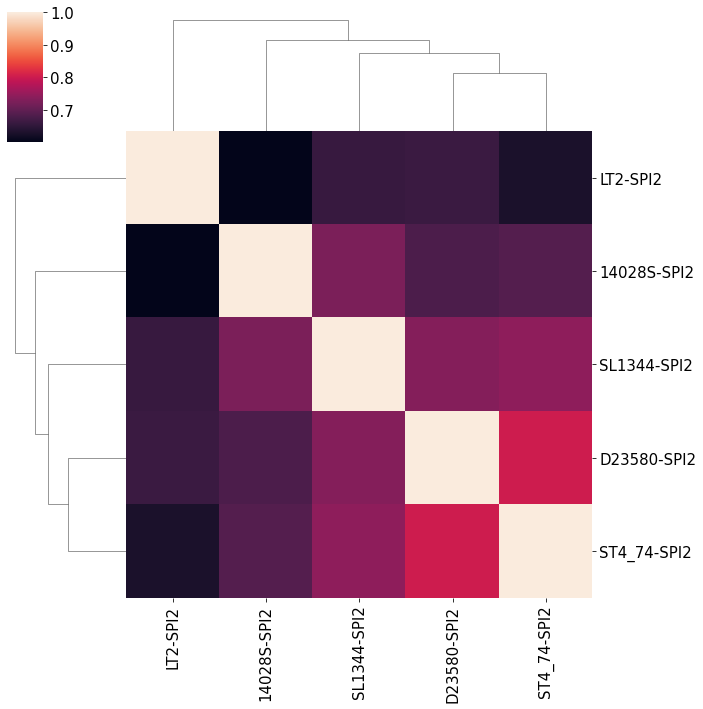

In [55]:
g = sns.clustermap(SPI2_DF)
figure = plt.gcf()
figure.savefig('../Figures/F4f.pdf',transparent=True)

## SPI-2 UpSet plot

In [56]:
strains = ['LT2','14028S','SL1344','ST4_74','D23580']
my_dict = {}
for strain in strains:
    strain_json = load_json_model('../json/'+ strain + '.json')
    bbh = pd.read_csv(path.join('../pangenome/bbh_results/' + strain + '_vs_LT2_parsed.csv'),index_col=0)
    bbh = bbh[['gene','subject']]
    strain_spi2 = strain_json.view_imodulon('SPI2')
    for name in strain_spi2.index:
        if name in list(bbh.gene):
            idx = list(bbh.gene).index(name)
            tag = list(bbh.subject)[idx]
            strain_spi2.at[name,'gene_name'] = tag
        else: strain_spi2.at[name,'gene_name'] = name
    my_dict[strain] = set(strain_spi2.gene_name)

In [57]:
LT2_spi2 = my_dict['LT2']
SL1344_spi2 = my_dict['SL1344']
_14028S_spi2 = my_dict['14028S']
ST4_74_spi2 = my_dict['ST4_74']
D23580_spi2 = my_dict['D23580']

In [58]:
core_spi2 = set(ica_data.view_imodulon('SPI2').index)

In [59]:
#Same gene in different strains
ST4_74_spi2.add('STMMW_19812')
ST4_74_spi2.remove('STM474_2032')

ST4_74_spi2.add('STMMW_22711')
ST4_74_spi2.remove('STM474_2335')

SL1344_spi2.add('STMMW_19812')
SL1344_spi2.remove('SL1344_1928')

In [60]:
my_dict = {'Core':core_spi2,'LT2':LT2_spi2,'SL1344':SL1344_spi2,
           'D23580':D23580_spi2,'ST4_74': ST4_74_spi2,'14028S':_14028S_spi2}

In [61]:
SPI2 = from_contents(my_dict)
SPI2

id
Core  LT2   SL1344 D23580 ST4_74 14028S             
True  True  True   True   True   True        STM2780
                                 True        STM1420
                                 True        STM1408
                                 True        STM1601
      False True   True   True   True        STM2137
...                                              ...
False False False  False  True   False   STM474_1578
                                 False       STM0940
                          False  True     STM14_1692
                                 True     STM14_1719
                                 True     STM14_2823

[177 rows x 1 columns]

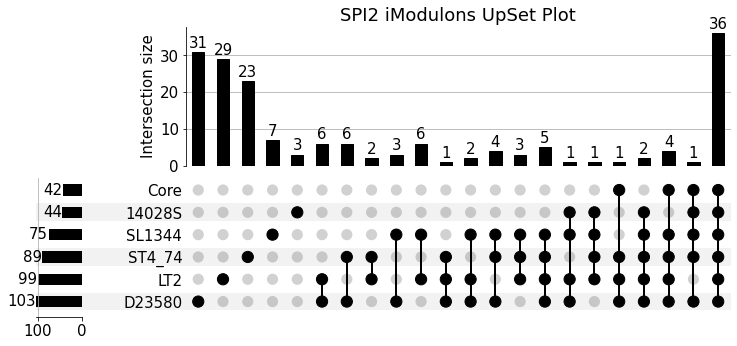

In [62]:
UpSet(SPI2,show_counts=True).plot()
plt.title('SPI2 iModulons UpSet Plot')
plt.savefig('../Figures/F4g.pdf',transparent=True)

# Figure 5

## Activity clusters

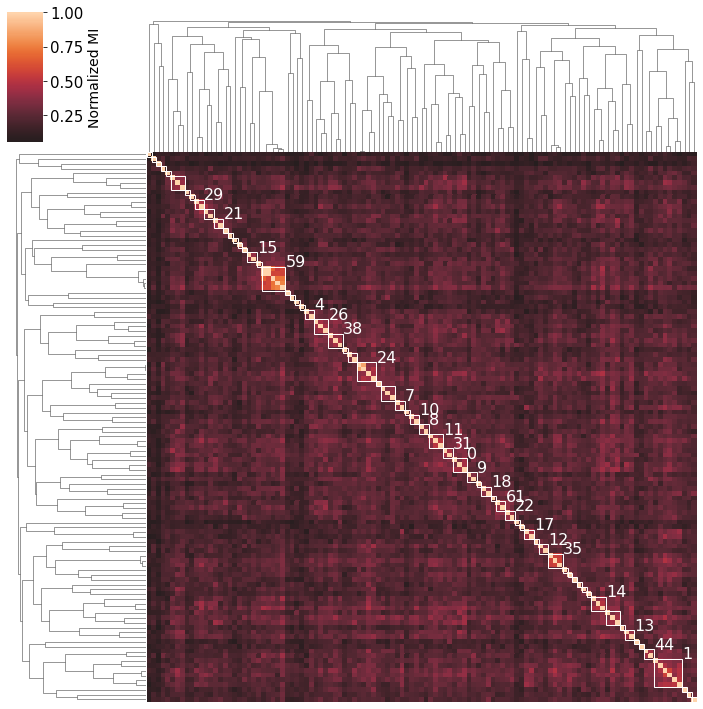

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.9, linkage='complete',
                         n_clusters=None)]

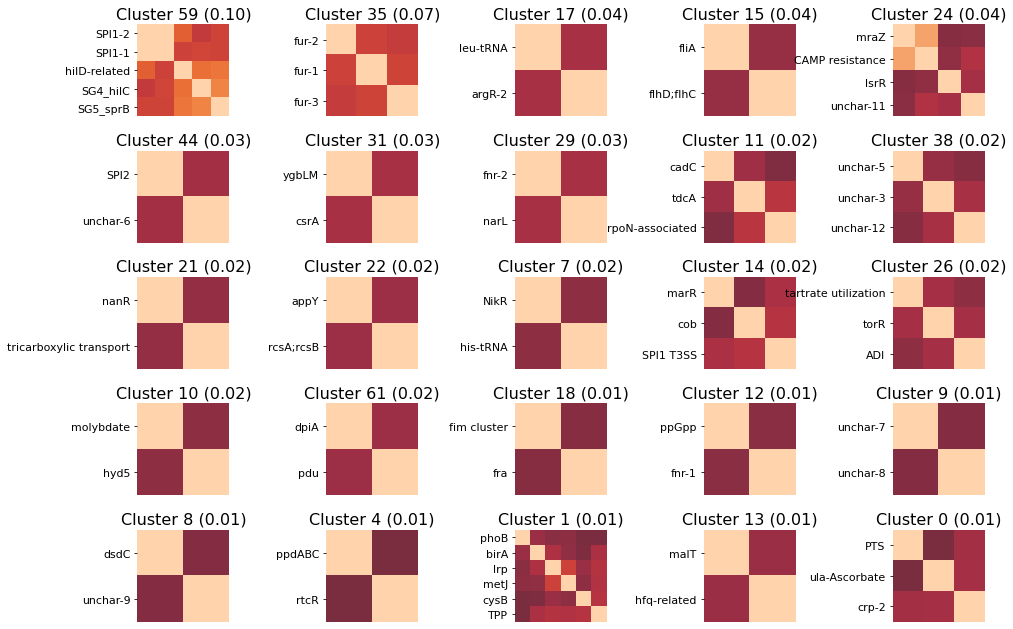

In [63]:
cluster_activities(ica_data,
#                    distance_threshold=0.88,
                   show_best_clusters=True,
                   correlation_method = 'mutual_info')

<AxesSubplot:xlabel='mraZ iModulon Activity', ylabel='CAMP resistance iModulon Activity'>

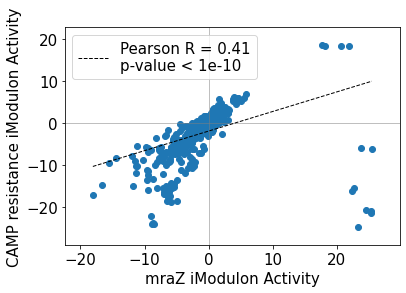

In [64]:
compare_activities(ica_data,'mraZ','CAMP resistance')

<AxesSubplot:xlabel='SPI2 iModulon Activity', ylabel='unchar-6 iModulon Activity'>

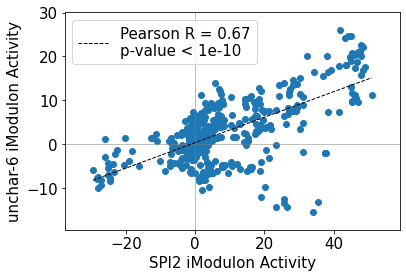

In [65]:
compare_activities(ica_data,'SPI2','unchar-6')

## CAMP resistance

In [66]:
cat = dict(collections. Counter(ica_data.view_imodulon('CAMP resistance')['COG']))

In [67]:
l = ica_data.view_imodulon('CAMP resistance').shape[0]
key = []
val = []
for k in cat:
    pct = round(100*cat[k]/l, 2)
    key.append(str(k)+ '(' + str(cat[k]) + ')')
    val.append(cat[k])

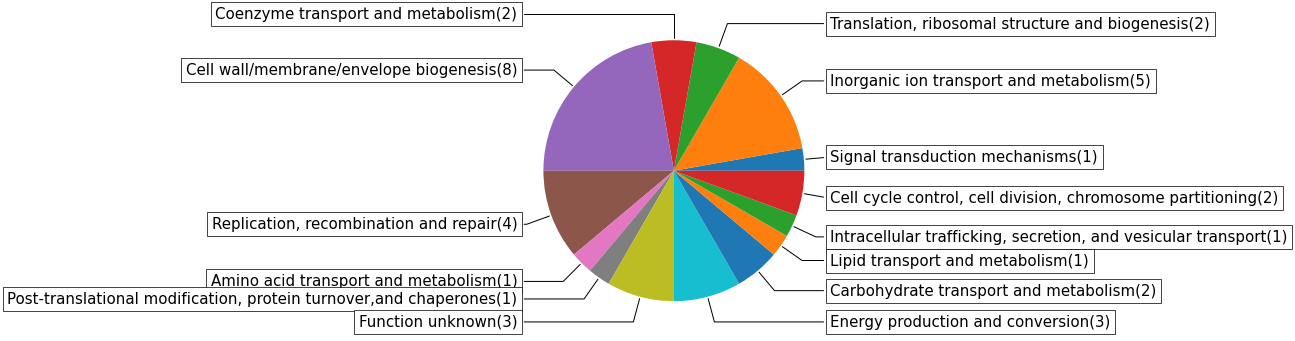

In [68]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(val)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(key[i], xy=(x, y), xytext=(1.2*np.sign(x),1.2*y),
                horizontalalignment=horizontalalignment, **kw)
None
plt.savefig('../Figures/F5b.pdf',transparent=True)

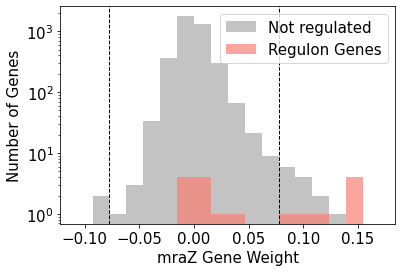

In [69]:
plot_regulon_histogram(ica_data,'mraZ','mraZ')
figure = plt.gcf()
figure.savefig('../Figures/F5c.pdf',transparent=True)

In [70]:
mraz = set(['STM0119','STM0120','STM0121','STM0122','STM0123','STM0124','STM0125','STM0126','STM0127','STM0128',
        'STM0129','STM0130','STM0131','STM0132','STM0133','STM0134','STM3875'])

In [71]:
mraz_imod = set(ica_data.view_imodulon('mraZ').index)

In [72]:
mraz-mraz_imod

{'STM0119',
 'STM0120',
 'STM0121',
 'STM0122',
 'STM0123',
 'STM0124',
 'STM0125',
 'STM0133',
 'STM0134',
 'STM3875'}

In [73]:
mraz_imod-mraz

{'STM0229',
 'STM0230',
 'STM0231',
 'STM2088',
 'STM2993',
 'STM3615',
 'STM3616',
 'STM3696',
 'STM3699',
 'STM3715',
 'STM3717',
 'STM3926',
 'STM3927',
 'STM3929',
 'STM4155'}

# Figure 6

## unchar-1 composition

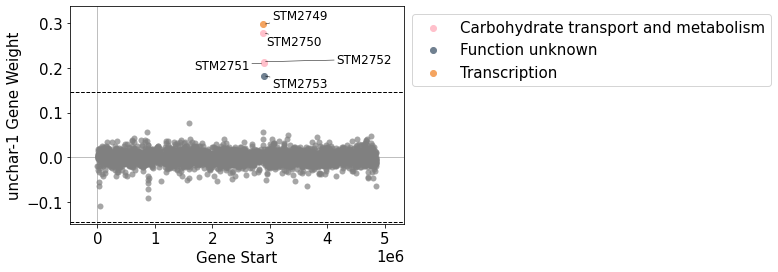

In [74]:
plot_gene_weights(ica_data,'unchar-1')
figure = plt.gcf()
figure.savefig('../Figures/F6a.pdf',transparent=True)

## unchar-1 strain boxplot

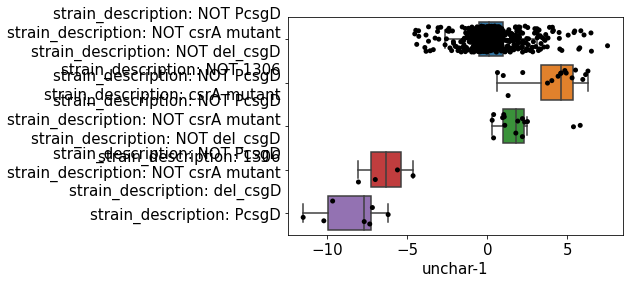

In [75]:
metadata_boxplot(ica_data,'unchar-1',use_cols=['strain_description'],n_boxes=5)
figure = plt.gcf()
figure.savefig('../Figures/F6b.pdf',transparent=True)

## unchar-1 csgD DIMA plot

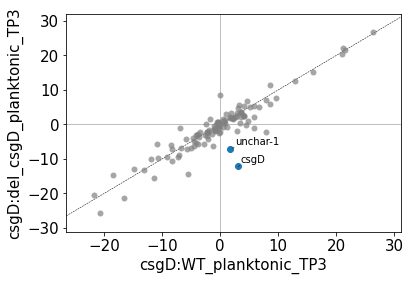

In [76]:
plot_dima(ica_data,'csgD:WT_planktonic_TP3','csgD:del_csgD_planktonic_TP3')
figure = plt.gcf()
figure.savefig('../Figures/F6c.pdf',transparent=True)

## tartrate utilization iModulon

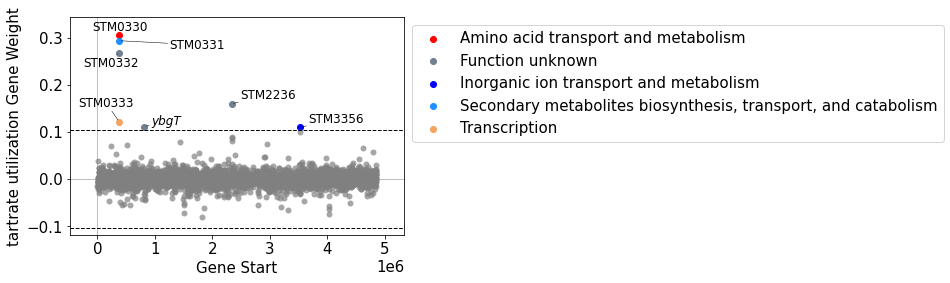

In [77]:
plot_gene_weights(ica_data,'tartrate utilization',show_labels=True)
figure = plt.gcf()
figure.savefig('../Figures/F6d.pdf',transparent=True)

## tartrate utilization metadata boxplot

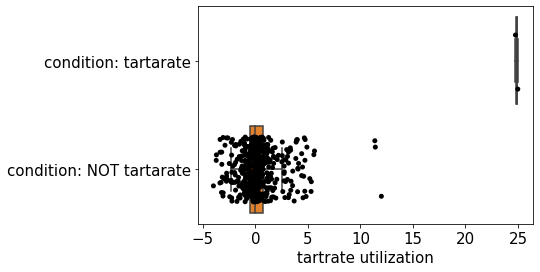

In [78]:
metadata_boxplot(ica_data,'tartrate utilization',use_cols=['condition'],n_boxes=2)
figure = plt.gcf()
figure.savefig('../Figures/F6e.pdf',transparent=True)

# Supplements

## S1

In [79]:
DF_metadata = pd.read_csv('../data/Core/raw_data/Salmonella_enterica.csv')

In [80]:
d = dict(collections.Counter(list(DF_metadata.ScientificNameCurated)))
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]))

In [81]:
df = pd.DataFrame({"Strains":list(sorted_d.keys()),
                  "Num":list(sorted_d.values())})

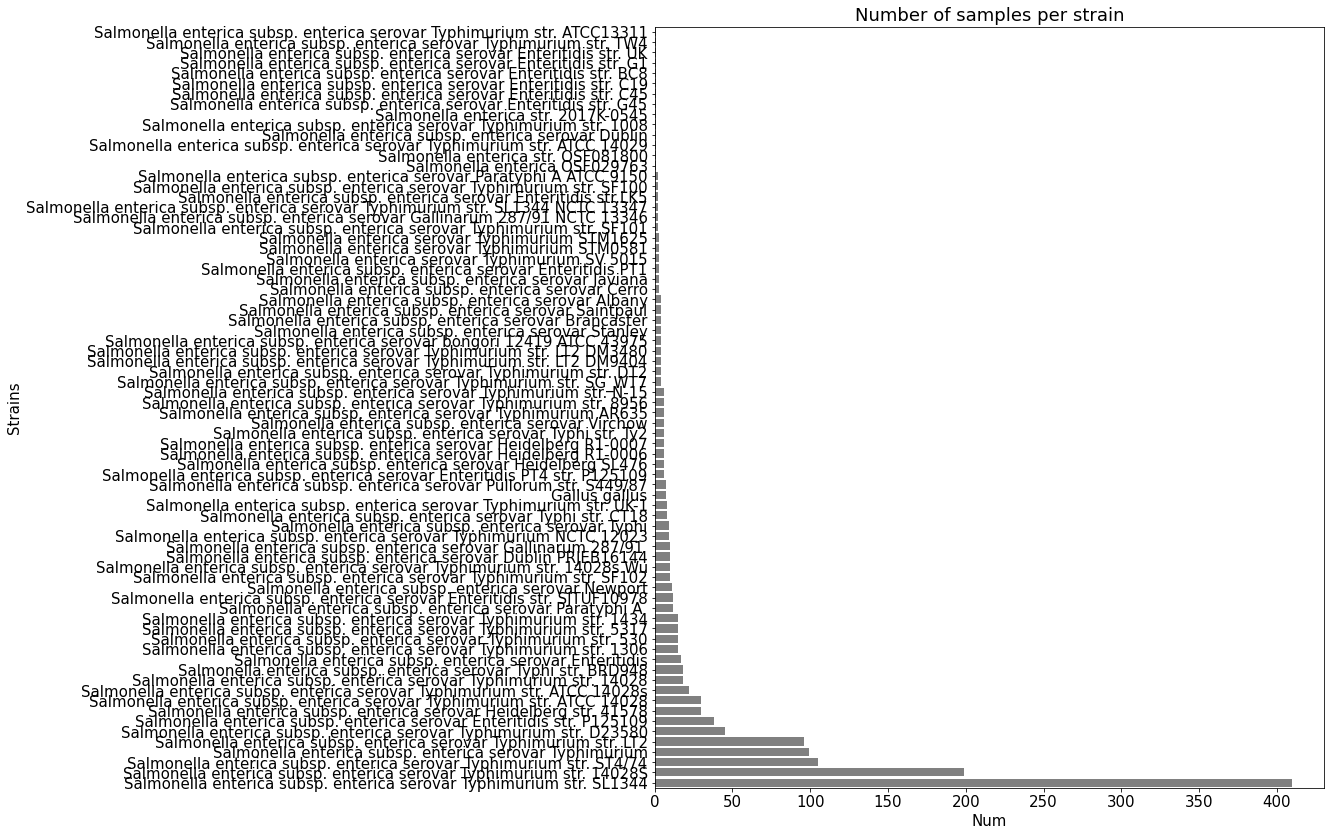

In [82]:
plt.figure(figsize=[12,14])
sns.barplot(x='Num',
            y="Strains", 
            data=df, 
            order=df.sort_values('Num').Strains,
            orient = 'h',
            color = 'gray')
plt.title('Number of samples per strain')
plt.savefig('../Figures/Supplements/S1.pdf',transparent=True)

## S2

See R notebook

## S3

In [83]:
variance = []
for i in ica_data.imodulon_table.index:
    exp_var = explained_variance(ica_data,imodulons=i)
    variance.append(exp_var)

In [84]:
variance = pd.DataFrame(variance, index = ica_data.imodulon_table.index, columns = ['Explained Variance'])
variance = variance.sort_values(by='Explained Variance', ascending = False)

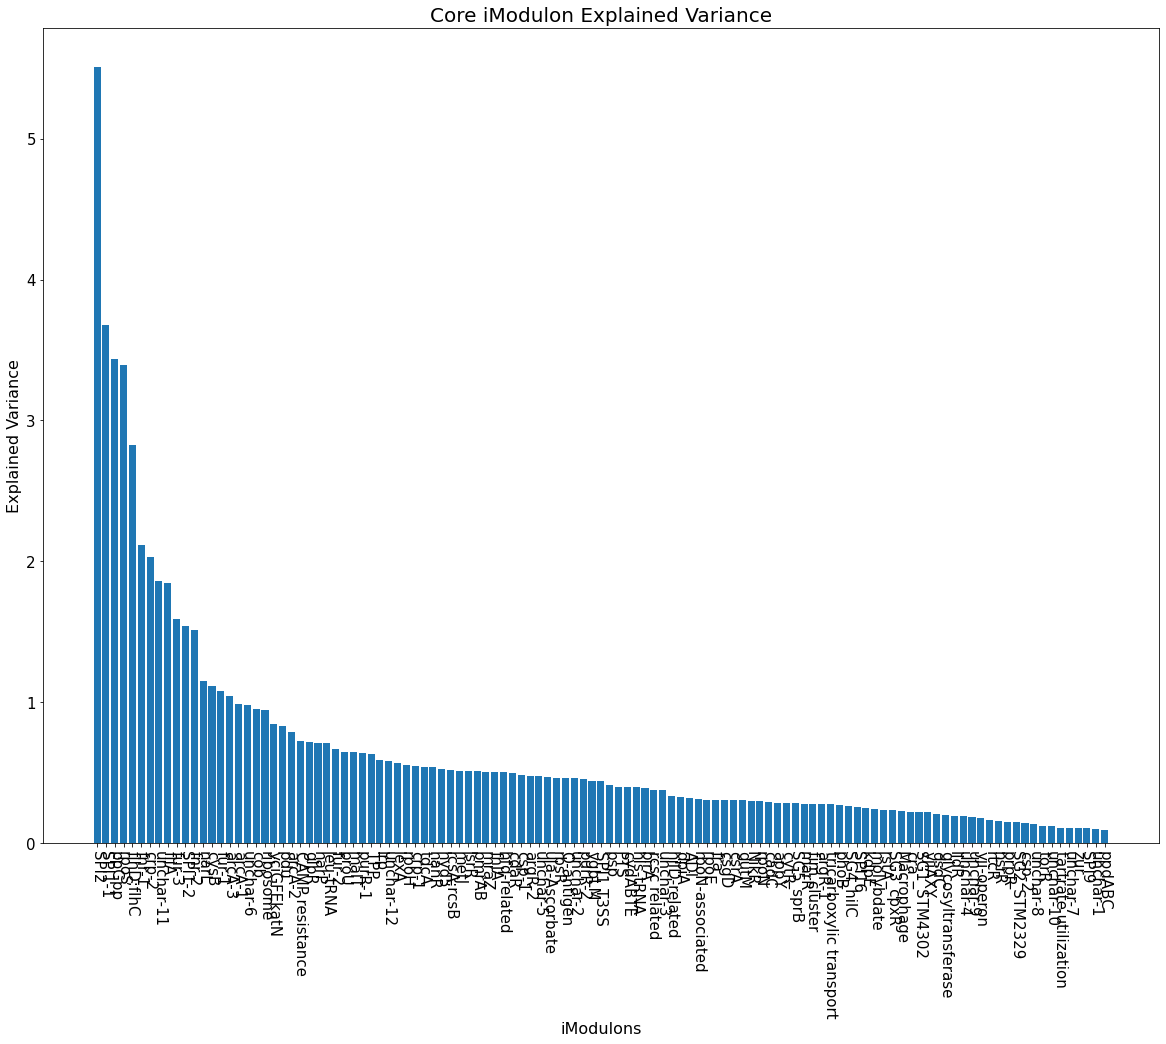

In [85]:
plt.figure(figsize=(20,15))
plt.xticks(rotation=-90)  #rotation=-90
plt.bar(variance.index,variance['Explained Variance'],label='Explained Variance')
plt.xlabel('iModulons',fontsize=16)
plt.ylabel('Explained Variance',fontsize=16)
plt.title('Core iModulon Explained Variance',fontsize=20)
plt.savefig('../Figures/Supplements/S3.pdf',transparent=True)

## S4

See R notebook

## S5

In [86]:
dot = Digraph(engine='circo',graph_attr={'splines':'false','bgcolor':'transparent'})
nodes = []
for i,row in DF_links.iterrows():
    node1 = row.strain1+'_'+str(row.imod1)
    node2 = row.strain2+'_'+str(row.imod2)
    
    if node1 not in nodes:
        dot.node(node1,shape='circle',label=node1,width='.2',tooltip=node1,
                 height='.2',fillcolor=strain_color[row.strain1],
                 style='filled',color='black',penwidth='1')
        
    if node2 not in nodes:
        dot.node(node2,shape='circle',label=node2,width='.2',tooltip=node2,
                 height='.2',fillcolor=strain_color[row.strain2],
                 style='filled',color='black',penwidth='1')   
        
    dot.edge(node1,node2,_attributes={'arrowhead':'none','color':get_edge_color(row.distance),
                                      'penwidth':'{:.2f}'.format(8*(row.distance))})

In [87]:
dot.render('../Figures/Supplements/S5')

'../Figures/Supplements/S5.pdf'

## S6

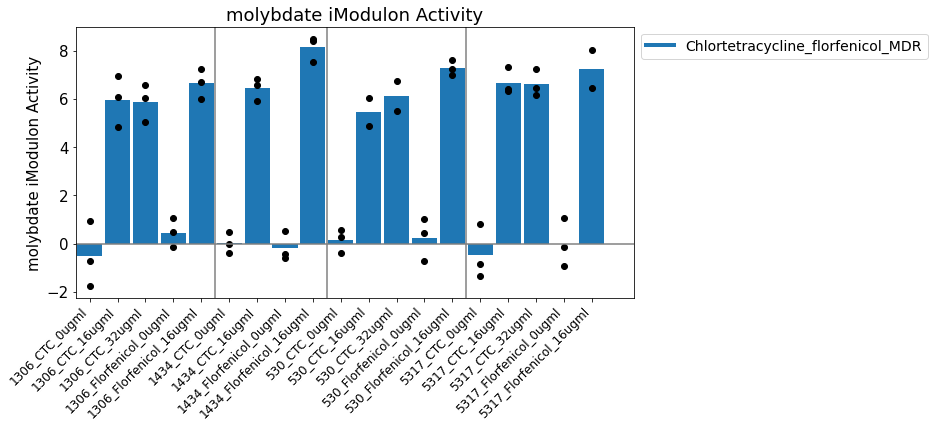

In [88]:
#Put projects of interest here
projects = ['Chlortetracycline_florfenicol_MDR']
#Put IMod whose activities you would like to look at here
imod = "molybdate"   
cmap = plt.cm.get_cmap("tab10")
colors = cmap(np.arange(cmap.N))
fig,ax = plt.subplots(figsize=[10,5])
seperators = []
dots = []

labels=["1306_CTC_0ugml", "1306_CTC_16ugml", "1306_CTC_32ugml",
        "1306_Florfenicol_0ugml","1306_Florfenicol_16ugml","1434_CTC_0ugml",
       "1434_CTC_16ugml","1434_Florfenicol_0ugml", "1434_Florfenicol_16ugml",
        "530_CTC_0ugml","530_CTC_16ugml","530_CTC_32ugml",
        "530_Florfenicol_0ugml","530_Florfenicol_16ugml","5317_CTC_0ugml",
        "5317_CTC_16ugml","5317_CTC_32ugml","5317_Florfenicol_0ugml",
       "5317_Florfenicol_16ugml"]

label_count = 0
color_count = 0

for i,j in ica_data.sample_table.groupby(["project","condition"]):
    if i[0] == projects[0]:
        dots.append(list(ica_data.A[j.index].loc[imod]))
        ax.bar(labels[label_count],ica_data.A[j.index].mean(axis=1)[imod],
               width=.9,color=colors[color_count])
        label_count +=1 
    
color_count += 1

sep_pos = -.5
dot_pos = 0
    
for condition in dots:
    for dot in condition:
        ax.plot(dot_pos,dot,"ko")
    dot_pos+=1
    
non_mifH = ica_data.A.loc[imod]
for i in projects:
    non_mifH = non_mifH.drop(list(ica_data.sample_table.loc[ica_data.sample_table["project"]==i].index))
mean = non_mifH.mean()
std_dev = non_mifH.std()

ylimits = ax.get_ylim()
ax.set_xlim([-.5,label_count+.5])
ax.plot(list(ax.get_xlim()),[0,0],color="gray")
ax.set_ylim(ylimits)
ax.set_ylabel(imod+" iModulon Activity",fontsize=15)

seperators = [5,4,5]
for cord in seperators:
    sep_pos+=cord
    ax.plot([sep_pos,sep_pos],ylimits,color="gray")

custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
ax.legend(custom_lines,projects,bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)

plt.xticks(labels,fontsize=12)
plt.title("molybdate iModulon Activity")
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

plt.savefig('../Figures/Supplements/S6a.pdf',transparent=True)

## S7

### unchar-12 category breakdown

In [89]:
cat = dict(collections. Counter(ica_data.view_imodulon('unchar-12')['COG']))

In [90]:
l = ica_data.view_imodulon('unchar-12').shape[0]
key = []
val = []
for k in cat:
    pct = round(100*cat[k]/l, 2)
    key.append(str(k)+ '(' + str(cat[k]) + ')')
    val.append(cat[k])

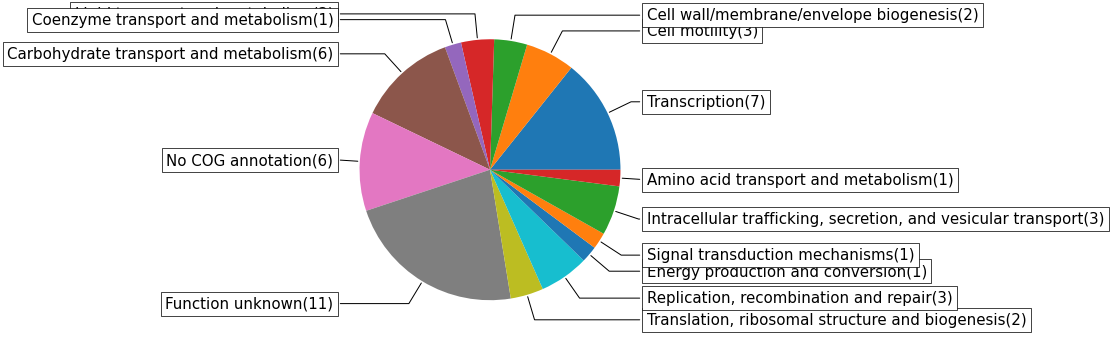

In [91]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(val)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(key[i], xy=(x, y), xytext=(1.2*np.sign(x),1.2*y),
                horizontalalignment=horizontalalignment, **kw)
None
plt.savefig('../Figures/Supplements/S7a.pdf',transparent=True)

### unchar-5 metadata boxplot

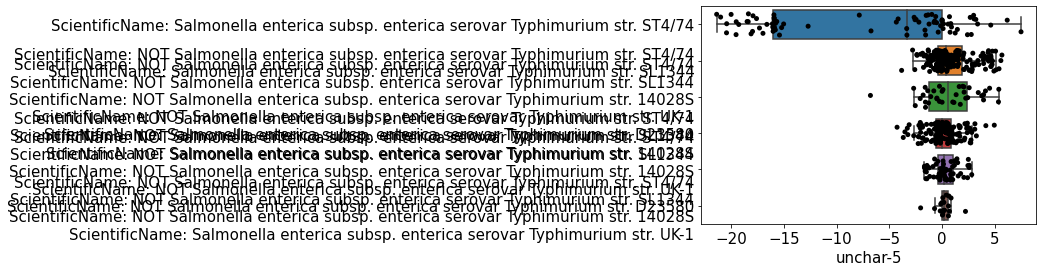

In [92]:
metadata_boxplot(ica_data,'unchar-5',use_cols=['ScientificName'],n_boxes=10)
figure = plt.gcf()
figure.savefig('../Figures/Supplements/S7b.pdf',transparent=True)

### unchar-12 metadata boxplot

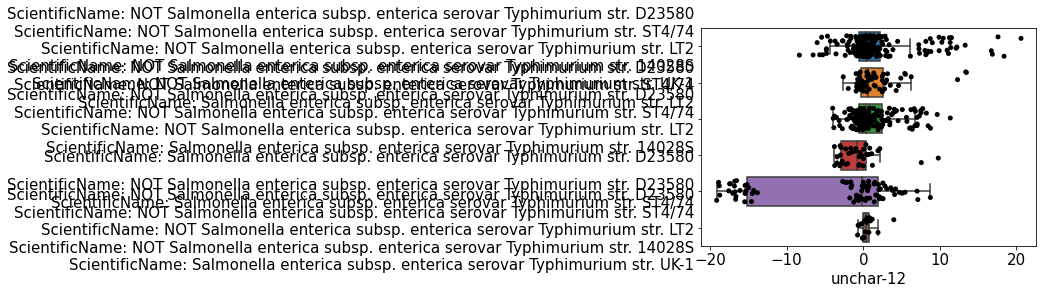

In [93]:
metadata_boxplot(ica_data,'unchar-12',use_cols=['ScientificName'],n_boxes=10)
figure = plt.gcf()
figure.savefig('../Figures/Supplements/S7c.pdf',transparent=True)

### ST4/74 Bile shock DIMA plot

In [94]:
diff = ['fur-2','SPI9','unchar-3','unchar-5','unchar-12']
idx = ica_data.sample_table[ica_data.sample_table.condition=='st474_Bile_shock'].index
df = ica_data.A[idx].sort_values(by=['SRX4665709'])

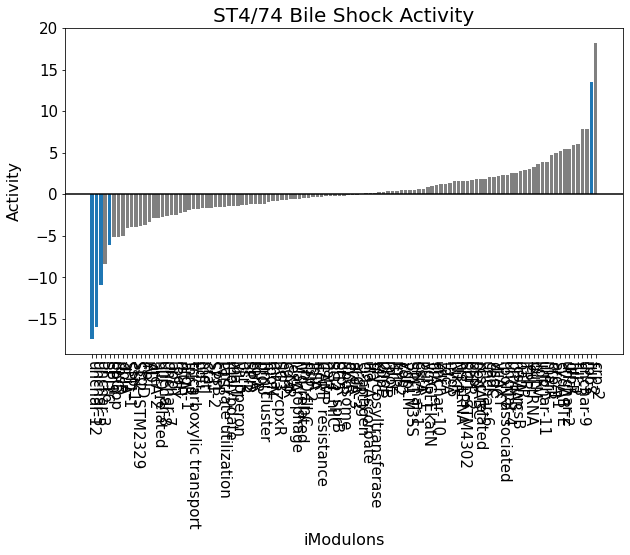

In [95]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=-90)  #rotation=-90
plt.bar(df.index,df['SRX4665709'],label='1D DIMA plot',color='grey')
plt.bar(diff,df['SRX4665709'].loc[diff])
plt.axhline(y=0,color='black')
plt.title('ST4/74 Bile Shock Activity',fontsize=20)
plt.xlabel('iModulons',fontsize=16)
plt.ylabel('Activity',fontsize=16)
plt.savefig('../Figures/Supplements/S7d.pdf',transparent=True)

In [96]:
# plot_dima(ica_data,'comparative_st474:st474_MEP','comparative_st474:st474_Bile_shock')
# figure = plt.gcf()
# figure.savefig('../Figures/Supplements/S7d.pdf',transparent=True)

### ST4/74 vs D23580 Bile shock DIMA plot

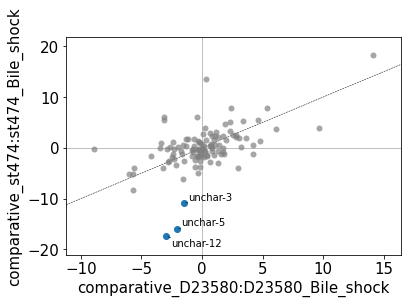

In [97]:
plot_dima(ica_data,'comparative_D23580:D23580_Bile_shock','comparative_st474:st474_Bile_shock')
figure = plt.gcf()
figure.savefig('../Figures/Supplements/S7e.pdf',transparent=True)

### Compare activity plots

<AxesSubplot:xlabel='unchar-3 iModulon Activity', ylabel='unchar-5 iModulon Activity'>

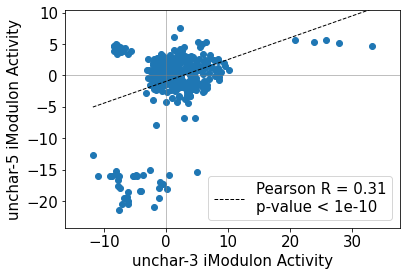

In [98]:
compare_activities(ica_data,'unchar-3','unchar-5')

<AxesSubplot:xlabel='unchar-3 iModulon Activity', ylabel='unchar-12 iModulon Activity'>

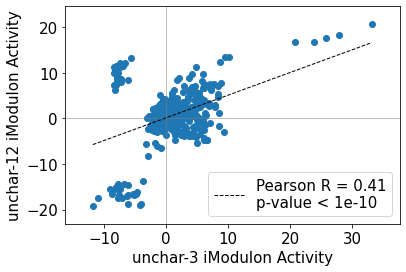

In [99]:
compare_activities(ica_data,'unchar-3','unchar-12')

<AxesSubplot:xlabel='unchar-5 iModulon Activity', ylabel='unchar-12 iModulon Activity'>

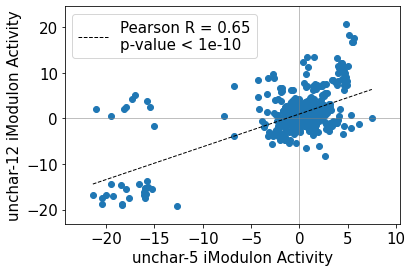

In [100]:
compare_activities(ica_data,'unchar-5','unchar-12')

# S8

In [101]:
cat = dict(collections. Counter(ica_data.view_imodulon('unchar-3')['COG']))

In [102]:
l = ica_data.view_imodulon('unchar-3').shape[0]
key = []
val = []
for k in cat:
    pct = round(100*cat[k]/l, 2)
    key.append(str(k)+ '(' + str(cat[k]) + ')')
    val.append(cat[k])

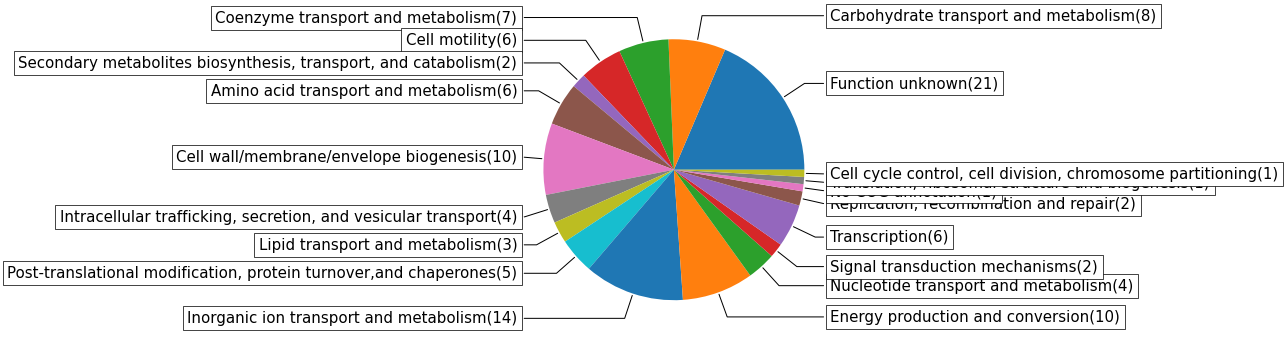

In [103]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(val)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(key[i], xy=(x, y), xytext=(1.2*np.sign(x),1.2*y),
                horizontalalignment=horizontalalignment, **kw)
None
plt.savefig('../Figures/Supplements/S8.pdf',transparent=True)

# S9&S10

Use the ica_dimensionality notebook